### https://github.com/ledmaster/TutorialTitanic

In [62]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
%matplotlib inline
%pylab inline

In [2]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [3]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Exemplo bobo de como gerar o gender_submission

In [4]:
e_feminino = (test['Sex'] == 'female').astype(int)
e_feminino.index = test['PassengerId']
e_feminino.name = 'Survived'
e_feminino.head()


## Mostrando como a geração de dados de treino e teste funcionam

In [59]:
X_falso = np.arange(10)
X_falso

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [63]:
np.random.seed(0)
train_test_split(X_falso, test_size=0.5)

[array([6, 7, 3, 0, 5]), array([2, 8, 4, 9, 1])]

In [64]:
X_treino, X_valid, y_treino, y_valid = train_test_split(X, y, test_size=0.5)

In [68]:
X_treino.shape, X_valid.shape, y_treino.shape, y_valid.shape

((445, 2), (446, 2), (445,), (446,))

In [94]:
X_valid.head()

,Sex_binario,Age
247,1,24.0
596,1,-1.0
531,0,-1.0
384,0,-1.0
642,1,2.0


In [82]:
modelo = RandomForestClassifier(n_estimators=100, n_jobs=10, random_state=1)
modelo.fit(X_treino, y_treino)

RandomForestClassifier(n_jobs=10, random_state=1)

In [90]:
p = modelo.predict(X_valid)
np.mean(y_valid == p)

0.7354260089686099

In [99]:
# Seta em P,  true todas as mulheres do set de validacao
p = (X_valid['Sex_binario'] == 1).astype(np.int64)
# Traz a relaçao das mulheres que sobreviveram (sobreviveu = mulheres), sobre o total
np.mean(y_valid == p)

0.7802690582959642

## Daqui pra baixo é realmente a geração do modelo

In [19]:
def transformar_sexo(valor):
    if valor == 'female':
        return 1
    elif valor == 'male':
        return 0

In [20]:
# Pega os dados da coluna SEX e aplica na funcao dentro do MAP
train['Sex_binario'] = train['Sex'].map(transformar_sexo)

In [ ]:
train.head()

In [92]:
features = ['Sex_binario','Age']
X = train[features]
y = train['Survived'] # ou train.Survived usando o pandas

In [31]:
X.head()

,Sex_binario,Age
0,0,22.0
1,1,38.0
2,1,26.0
3,1,35.0
4,0,35.0


In [28]:
y.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [33]:
# Se quiser preencher a coluna Sex_binario
# X['Sex_binario'] = X['Sex_binario'].fillna(-1)
X = X.fillna(-1)

In [38]:
# Criar a mesma coluna convertiva do Sex para Sex_binario nos dados de test
test['Sex_binario'] = test['Sex'].map(transformar_sexo)
# X_pred é o dataset com as features que escolhemos para fazer os testes (previsao)
X_pred = test[features]
X_pred = X_pred.fillna(-1)

In [53]:
model = RandomForestClassifier(n_estimators=100, n_jobs=10, random_state=0)
model.fit(X, y) # X e y sao da base de train
y_pred = model.predict(X_pred)

# Melhoria do modelo

## Validação cruzada

In [ ]:
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import accuracy_score

In [ ]:
# Features iniciais de teste
features = ['Sex_binario','Age']
X = train[features].fillna(-1)
y = train['Survived'] # ou train.Survived usando o pandas

In [ ]:
train.head()

In [134]:
features = ['Sex_binario', 'Age', 'Pclass','SibSp','Parch','Fare']
X = train[features].fillna(-1)
y = train['Survived'] # ou train.Survived usando o pandas

In [ ]:
resultados = []
kf = RepeatedKFold(n_splits=2, n_repeats=10, random_state=0)

for linhas_treino, linhas_valid in kf.split(X):
    print(f'Treino: {linhas_treino.shape[0]}')
    print(f'Valid: {linhas_valid.shape[0]}')
    print()

    X_treino, X_valid = X.iloc[linhas_treino], X.iloc[linhas_valid]
    y_treino, y_valid = y.iloc[linhas_treino], y.iloc[linhas_valid]

    modelo = RandomForestClassifier(n_estimators=100, n_jobs=10, random_state=1)
    modelo.fit(X_treino, y_treino)

    p = modelo.predict(X_valid)
    acc = accuracy_score(y_valid, p)
    resultados.append(acc)
    print(f'Acc: {acc}')
    print()

(array([5., 0., 5., 1., 0., 3., 2., 2., 1., 1.]),
 array([0.77802691, 0.78426916, 0.79051141, 0.79675367, 0.80299592,
        0.80923817, 0.81548043, 0.82172268, 0.82796493, 0.83420718,
        0.84044944]),
 <BarContainer object of 10 artists>)

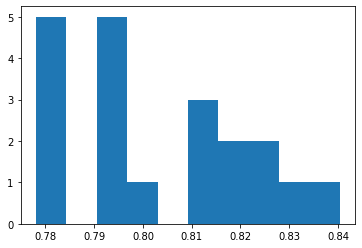

In [136]:
pylab.hist(resultados)

In [137]:
np.mean(resultados)

0.8034841537763894

## Criar submissao

In [46]:
sub = pd.Series(y_pred, index=test['PassengerId'], name='Survived')

In [52]:
sub.to_csv("modelo_para_enviar_kaggle.csv", header=True)

In [ ]:
!more "modelo_para_enviar_kaggle.csv"